# 0. Libraries and importing data

## Libraries

In [492]:
import os
import pandas as pd
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns

# PanelSplit utilities
from panelsplit.cross_validation import PanelSplit
from panelsplit.application import cross_val_fit_predict  # Fit the estimator using cross-validation and then make predictions

# ML models
from sklearn.ensemble import RandomForestClassifier

# Homework library
from hw1_library import feature_engineering, evaluation

## Importing the data

We import:
1. The target data frames (the ones containing the protest incidence for each state, month and issue from 2017-01 to 2025-04).
2. The aggregated LDA topic share stock for US states from 2017-01 to 2025-03.
3. The aggregated Google Trends data for all of the US states (including dependent territories, like Puerto Rico) from 2015-01 to 2025-05.

Since the lowest common denominator of the last period for all three data frames is 2025-03, this should be the last period for all the data. Consequently, below we artificially add another null value in the target data frames to the month 2024-10 (which was not null before since 2025-04 is known in the original data frames).

In [493]:
# Set the root folder for the clean data
data = 'clean_data/'

In [494]:
# 1. Import the target data frames

# List all of the .csv in clean_data which begin with incidence_ and end with .csv
inc_healthcare = pd.read_csv(os.path.join(data, 'incidence_healthcare.csv'))
inc_housing = pd.read_csv(os.path.join(data, 'incidence_housing.csv'))
inc_racism = pd.read_csv(os.path.join(data, 'incidence_racism.csv'))  # Topic for racism and immigration
inc_violence = pd.read_csv(os.path.join(data, 'incidence_violence.csv'))  # Topic for guns and criminal justice

# Save all of the target data frames in a dictionary
target_dict = {
    'healthcare': inc_healthcare,
    'housing': inc_housing,
    'racism_and_immigration': inc_racism,
    'guns_and_criminal_justice': inc_violence
}

# Remove the "target" column from the data frames (same as 'target')
for key in target_dict.keys():

    target_dict[key] = target_dict[key].drop(columns=['anytarget_th0'])

    # Rename the columns for the target data frames to have a clearer name
    target_dict[key] = target_dict[key].rename(columns={'target': 'anymajorprotest', 'inc_anytarget_th0_h6': 'inc_anymajorprotest_th0_h6'})

    # Add a null value to the target data frames for the period 2024-10
    target_dict[key].loc[target_dict[key]['period'] == 202410, 'inc_anymajorprotest_th0_h6'] = np.nan

    # Remove the period 2025-04 from the target data frames
    target_dict[key] = target_dict[key].loc[target_dict[key]['period'] <= 202503]

    # Set a multiindex in the target data frames
    target_dict[key] = target_dict[key].set_index(['state', 'period']).sort_index()

# 2. Import the aggregated LDA topic stocks
lda_agg_stock = pd.read_csv(os.path.join(data, 'features', 'lda_shares_us', 'lda_agg_stock.csv'))

# Set the index to be the same as the target data frames
lda_agg_stock = lda_agg_stock.set_index(['state', 'period']).sort_index()

# 3. Import the aggregated Google Trends data
gtrends = pd.read_csv(os.path.join(data, 'features', 'google_trends', 'google_trends_per_state_month.csv'))

# Change the format of the month column to be YYYYMM, as an integer
gtrends['month'] = pd.to_datetime(gtrends['month']).dt.strftime('%Y%m').astype(int)

# Rename the month column to be period
gtrends = gtrends.rename(columns={'month': 'period'})

# Remove the periods previous to 2017-01 and 2025-04 and 2025-05 from the data frame
gtrends = gtrends.loc[(gtrends['period'] >= 201701) & (gtrends['period'] <= 202503)]

# Set the index to be the same as the target data frames
gtrends = gtrends.set_index(['state', 'period']).sort_index()

In [495]:
# Display all target data frames
for key in target_dict.keys():
    print(f"Target data frame for {key}:")
    display(target_dict[key].head())
    print("\n")

Target data frame for healthcare:


anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                1                         1.0            1.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  
state period                               
AK    201701               0.83       0.0  
      201702               0.83       0.0  
      201703               0.83       0.0  
      201704               0.83       0.0  
      201705               0.83       0.0



Target data frame for housing:


anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         0.0            0.0   
      201702                0                         0.0            0.0   
      201703                0                         0.0            0.0   
      201704                0                         0.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  
state period                               
AK    201701               0.08       0.0  
      201702               0.08       0.0  
      201703               0.08       0.0  
      201704               0.08       0.0  
      201705               0.08       0.0



Target data frame for racism_and_immigration:


anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                1                         0.0            2.0   
      201702                0                         1.0            0.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  
state period                               
AK    201701               1.16       0.0  
      201702               1.16       0.0  
      201703               1.16       0.0  
      201704               1.16       0.0  
      201705               1.16       0.0



Target data frame for guns_and_criminal_justice:


anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                0                         1.0            0.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  
state period                               
AK    201701               0.58       0.0  
      201702               0.58       0.0  
      201703               0.58       0.0  
      201704               0.58       0.0  
      201705               0.58       0.0

In [496]:
# Inspect in detail the healthcare target data frame
inc_health_mod = target_dict['healthcare']

inc_health_mod.head()

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                1                         1.0            1.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  
state period                               
AK    201701               0.83       0.0  
      201702               0.83       0.0  
      201703               0.83       0.0  
      201704               0.83       0.0  
      201705               0.83       0.0

In [497]:
print('Data frame for LDA aggregated stocks:')
display(lda_agg_stock.head())
print("\n")

print('Data frame for Google Trends:') 
display(gtrends.head())
print("\n")

Data frame for LDA aggregated stocks:


tokens  article_count  token_stock  stock_pr_topic_0  \
state period                                                         
AK    201701  2226.0             13    2226.0000          0.051113   
      201702  3876.0             18    5656.8000          0.168834   
      201703  5125.0             20    9650.4400          0.143892   
      201704  6214.0             22   13934.3520          0.100407   
      201705  5464.0             28   16611.4816          0.079710   

              stock_pr_topic_1  stock_pr_topic_2  stock_pr_topic_3  \
state period                                                         
AK    201701          0.097180          0.029021          0.051774   
      201702          0.048007          0.044735          0.041778   
      201703          0.046347          0.028465          0.027687   
      201704          0.057656          0.020909          0.024063   
      201705          0.050291          0.017649          0.024871   

              stock_pr_topic_4  stock_pr_topic_5  stock_pr_topic_6  \
state period                                                         
AK    201701          0.105650          0.069980          0.048580   
      201702          0.050353          0.060056          0.083743   
      201703          0.072717          0.055062          0.116458   
      201704          0.067274          0.078466          0.122143   
      201705          0.081926          0.064973          0.167928   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
AK    201701          0.164622          0.019698          0.017215   
      201702          0.159661          0.008003          0.006701   
      201703          0.159897          0.005196          0.005761   
      201704          0.113848          0.005452          0.004213   
      201705          0.094136          0.009029          0.004802   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201701           0.061863           0.009229           0.161179   
      201702           0.042831           0.018224           0.216510   
      201703           0.054533           0.010443           0.225568   
      201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
AK    201701           0.013923           0.098973  
      201702           0.015655           0.034910  
      201703           0.012891           0.035084  
      201704           0.026225           0.024089  
      201705           0.055474           0.060935



Data frame for Google Trends:


criminal justice  health  healthcare  immigrants  rent
state period                                                        
AK    201701                53      77          51        74.0    66
      201702                56      72          38       100.0    63
      201703                73      81          57        47.0    66
      201704                69      71          49        24.0    70
      201705                40      74          59        26.0    67

## Basic EDA

In [498]:
# Check for missing values
for key in target_dict.keys():
    print(f"Missing values in target data frame for {key}:")
    print(target_dict[key].isnull().sum())
    print("\n")

print('Missing values in LDA aggregated stocks:')
print(lda_agg_stock.isnull().sum())
print("\n")

print('Missing values in Google Trends:')
print(gtrends.isnull().sum())
print("\n")

Missing values in target data frame for healthcare:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    336
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for housing:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    336
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for racism_and_immigration:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    336
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for guns_and_criminal_justice:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    336
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in LDA aggreg

Explanation of the missing values:
- Target data frames: the missing values correspond to the last 6 periods for which we have data (from 2024-11 to 2025-04). As the future is not known (2025-05 is not complete), incidence cannot be computed, which leaves 6 (periods) times 56 (states) = 336 missing values per target data frame.
- Google Trends data: the missing values correspond to the fact that American Samoa did not have enough searches for *immigrants* in the period analyzed. 

In [499]:
# Check the shape of the data frames
for key in target_dict.keys():
    print(f"Shape of target data frame for {key}:")
    print(target_dict[key].shape)
    print("\n")

print('Shape of LDA aggregated stocks:')
print(lda_agg_stock.shape)
print("\n")

print('Shape of Google Trends:')
print(gtrends.shape)
print("\n")

Shape of target data frame for healthcare:
(5544, 5)


Shape of target data frame for housing:
(5544, 5)


Shape of target data frame for racism_and_immigration:
(5544, 5)


Shape of target data frame for guns_and_criminal_justice:
(5544, 5)


Shape of LDA aggregated stocks:
(5293, 18)


Shape of Google Trends:
(5544, 5)




In [500]:
# Do the unique states and periods in all data frames match?
# Get the unique states and periods in the target data frames
target_states = set()
target_periods = set()
for key in target_dict.keys():
    target_states.update(target_dict[key].index.get_level_values(0).unique())
    target_periods.update(target_dict[key].index.get_level_values(1).unique())

# Get the unique states and periods in the LDA aggregated stocks data frame
lda_states = set(lda_agg_stock.index.get_level_values(0).unique())
lda_periods = set(lda_agg_stock.index.get_level_values(1).unique())

# Get the unique states and periods in the Google Trends data frame
gtrends_states = set(gtrends.index.get_level_values(0).unique())
gtrends_periods = set(gtrends.index.get_level_values(1).unique())

# Check if the unique states and periods in all data frames match

if target_states == lda_states == gtrends_states:
    print("Unique states in target data frames match with LDA aggregated stocks and Google Trends.")
else:
    print("Unique states in target data frames do not match with LDA aggregated stocks and Google Trends.")
    # Difference in states in each combination
    print("States in target data frames but not in LDA aggregated stocks:", target_states - lda_states)
    print("States in target data frames but not in Google Trends:", target_states - gtrends_states)
    print("States in LDA aggregated stocks but not in target data frames:", lda_states - target_states)
    print("States in Google Trends but not in target data frames:", gtrends_states - target_states)
    print("States in LDA aggregated stocks but not in Google Trends:", lda_states - gtrends_states)
    print("States in Google Trends but not in LDA aggregated stocks:", gtrends_states - lda_states)


if target_periods == lda_periods == gtrends_periods:
    print("Unique periods in target data frames match with LDA aggregated stocks and Google Trends.")
else:
    print("Unique periods in target data frames do not match with LDA aggregated stocks and Google Trends.")
    # Difference in periods in each combination
    print("Periods in target data frames but not in LDA aggregated stocks:", target_periods - lda_periods)
    print("Periods in target data frames but not in Google Trends:", target_periods - gtrends_periods)
    print("Periods in LDA aggregated stocks but not in target data frames:", lda_periods - target_periods)
    print("Periods in Google Trends but not in target data frames:", gtrends_periods - target_periods)
    print("Periods in LDA aggregated stocks but not in Google Trends:", lda_periods - gtrends_periods)
    print("Periods in Google Trends but not in LDA aggregated stocks:", gtrends_periods - lda_periods)

Unique states in target data frames do not match with LDA aggregated stocks and Google Trends.
States in target data frames but not in LDA aggregated stocks: {'VM', 'TŒß'}
States in target data frames but not in Google Trends: {'VM', 'TŒß'}
States in LDA aggregated stocks but not in target data frames: {'MP', 'AS'}
States in Google Trends but not in target data frames: {'MP', 'AS'}
States in LDA aggregated stocks but not in Google Trends: set()
States in Google Trends but not in LDA aggregated stocks: set()
Unique periods in target data frames match with LDA aggregated stocks and Google Trends.


In [501]:
# We will remove all of the mismatched states from the data frames (dependent territories and unexpected characters)
mismatched_states = ['VM', 'TŒß', 'MP', 'AS']

for key in target_dict.keys():
    target_dict[key] = target_dict[key].loc[~target_dict[key].index.get_level_values(0).isin(mismatched_states)]
    target_dict[key] = target_dict[key].sort_index()

lda_agg_stock = lda_agg_stock.loc[~lda_agg_stock.index.get_level_values(0).isin(mismatched_states)]
lda_agg_stock = lda_agg_stock.sort_index()
gtrends = gtrends.loc[~gtrends.index.get_level_values(0).isin(mismatched_states)]
gtrends = gtrends.sort_index()

In [502]:
# Check for missing values
for key in target_dict.keys():
    print(f"Missing values in target data frame for {key}:")
    print(target_dict[key].isnull().sum())
    print("\n")

Missing values in target data frame for healthcare:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    324
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for housing:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    324
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for racism_and_immigration:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    324
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64


Missing values in target data frame for guns_and_criminal_justice:
anymajorprotest                 0
inc_anymajorprotest_th0_h6    324
protest_count                   0
avg_protest_count               0
violence                        0
dtype: int64




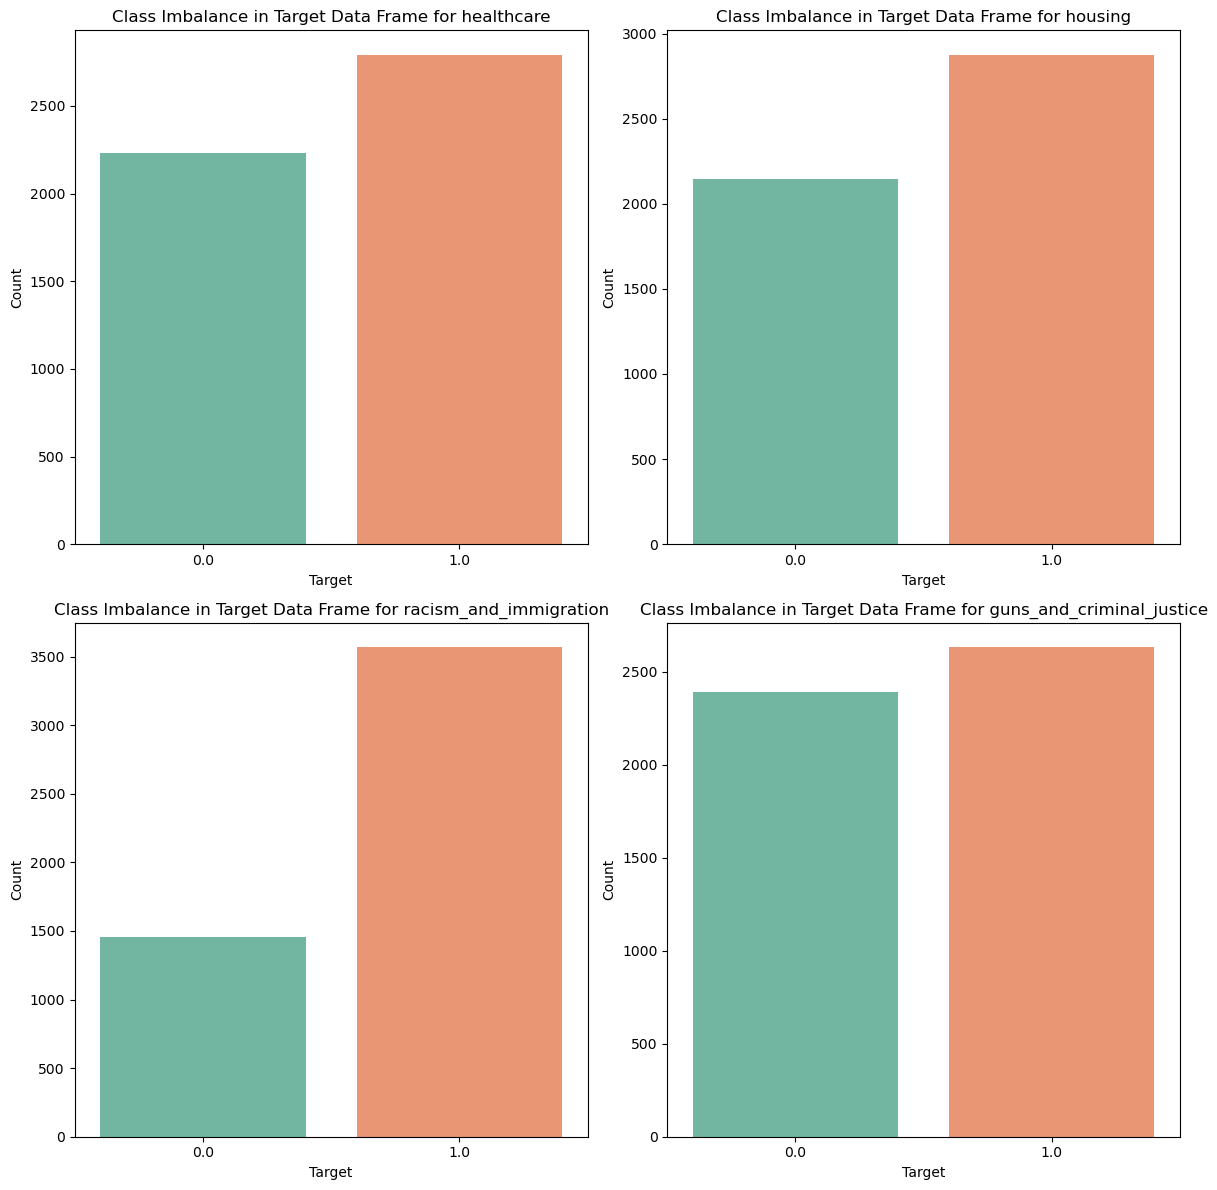

In [503]:
# Plot class imbalance for the target data frames

# Create a figure with 2 subplots per row and number of keys / 2 rows
num_keys = len(target_dict.keys())
num_rows = (num_keys + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
fig.subplots_adjust(hspace=0.4)

# Create a count plot for each target data frame
for i, key in enumerate(target_dict.keys()):
    ax = axes[i // 2, i % 2]  # Get the correct subplot
    sns.countplot(x='inc_anymajorprotest_th0_h6', data=target_dict[key], palette='Set2', hue='inc_anymajorprotest_th0_h6', ax=ax, legend=False)
    ax.set_title(f'Class Imbalance in Target Data Frame for {key}')
    ax.set_xlabel('Target')
    ax.set_ylabel('Count')
    plt.tight_layout()
plt.show()

# 1. Pipeline description

In other notebooks we have already created:
- `creating_incidence.ipynb`: the target variable (incidence of protests of certain issues - healthcare, housing, guns and criminal justice and racism and immigration).
- `aggregating_US_LDA_shares.ipynb`: the stock for LDA topic shares per month and US state.
- `aggregating_google_trends.ipynb`: Google Trends index per each month and US state, for the following terms:
  - *health* and *healthcare* (for the issue of *healthcare*).
  - *criminal justice* (for the issue of *guns and criminal justice*).
  - *rent* (for the issue of *housing*).
  - *immigrants* (for the issue of *immigration of racism*).

With the output from these notebooks as a starting point, in this notebook we make predictions for the incidence of violent protests related to certain issues, and evaluate the results with the precision-recall and ROC curves.

# 2. Feature engineering

As all of the features engineered in the class below only incorporate past data into the computation (and not future data), we can safely implement them without having to split the target data frame into as many data frames as train-test splits and then creating the features for each data frame.

Set of features that are used or created below:
1. Rolling weighted mean of the number of protests per issue for window sizes 1, 3 and 12.
2. Number of months since the number of protests related to a certain issue exceeed *x* (since).
3. Periods of consecutive months exceeding *x* (ongoing).
4. LDA stock topics.
5. Google Trends index for some keywords related to the protest issues.

In [504]:
# Initialize the FeatureEngineer class and set groupby columns to the state level
feature_engineer = feature_engineering.FeatureEngineer(groupby_cols = 'state')

## Weighted rolling mean

In [505]:
# 1. Rolling weighted mean of fatalities for window sizes of [1, 3, 12, 36, 60]

windows = [1, 3, 12]  # Window sizes (number of periods to consider for the rolling mean)

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_target = feature_engineer.weighted_rolling_mean(
        input_df = df_target,
        y_col = 'protest_count',  # Create weighted rolling variables with the number of protests per issue
        windows = windows,  # Window sizes (number of periods to consider for the rolling mean)
        closed = None,  # Include current period in the computation of the rolling mean
        return_logs = False,  # Do not return logs
        alpha = 0.8  # Decay factor for weights (higher alpha -> relevance of values more evenly distributed from the past and present periods)
    )
    target_dict[key] = df_target  # Update the target data frame in the dictionary

# Show results for the healthcare data frame
display(target_dict['healthcare'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['healthcare'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                1                         1.0            1.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.83       0.0   
      201702               0.83       0.0   
      201703               0.83       0.0   
      201704               0.83       0.0   
      201705               0.83       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   1.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                              0.000000   
      201702                              0.277778   
      201703                              0.109290   
      201704                              0.087432   
      201705                              0.000000   

              protest_count_weighted_rolling_mean12  
state period                                         
AK    201701                               0.000000  
      201702                               0.277778  
      201703                               0.109290  
      201704                               0.054201  
      201705                               0.030462

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                0                         NaN            0.0   
      202501                0                         NaN            0.0   
      202502                0                         NaN            0.0   
      202503                0                         NaN            0.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.49       0.0   
      202412               0.49       0.0   
      202501               0.49       0.0   
      202502               0.49       0.0   
      202503               0.49       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   0.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   0.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean12  
state period                                         
WY    202411                               0.004691  
      202412                               0.003753  
      202501                               0.003003  
      202502                               0.002402  
      202503                               0.001922

Note that, the higher the time window, the more we will consider a state's protest history.

## Since

In [506]:
# 2. Number of months since violence exceeed protest thresholds

thresholds = [2, 5, 10]  # Thresholds of protests to count since

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_since = feature_engineer.since(
        input_df = df_target,
        y_col = 'protest_count',  # Create since variables with number of fatalities
        thresholds = thresholds,  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
        shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
    )
    # Merge the since variables with the original target DataFrame
    target_dict[key] = pd.merge(
        df_target,
        df_since,
        on = ['state', 'period'],  # Merge on the multiindex columns
        how = 'outer',  # Outer join to keep all rows
        suffixes=(None, '_y')  # Suffixes for overlapping column names
    )
    # Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns) 
    target_dict[key] = target_dict[key].loc[:, ~target_dict[key].columns.str.endswith('_y')]  

# Show results for 
display(target_dict['racism_and_immigration'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['racism_and_immigration'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                1                         0.0            2.0   
      201702                0                         1.0            0.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               1.16       0.0   
      201702               1.16       0.0   
      201703               1.16       0.0   
      201704               1.16       0.0   
      201705               1.16       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   2.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                              2.000000   
      201702                              0.444444   
      201703                              0.174863   
      201704                              0.000000   
      201705                              0.000000   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                               2.000000                      1   
      201702                               0.444444                      2   
      201703                               0.174863                      3   
      201704                               0.086721                      4   
      201705                               0.048739                      5   

              protest_count_since_5  protest_count_since_10  
state period                                                 
AK    201701                      1                       1  
      201702                      2                       2  
      201703                      3                       3  
      201704                      4                       4  
      201705                      5                       5

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                1                         NaN            1.0   
      202501                1                         NaN            2.0   
      202502                1                         NaN            3.0   
      202503                1                         NaN            1.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.96       0.0   
      202412               0.96       0.0   
      202501               0.96       0.0   
      202502               0.96       0.0   
      202503               0.96       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   1.0   
      202501                                   2.0   
      202502                                   3.0   
      202503                                   1.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                              0.109290   
      202412                              0.224044   
      202501                              0.382514   
      202502                              0.715847   
      202503                              0.639344   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
WY    202411                               0.055562                      9   
      202412                               0.061116                     10   
      202501                               0.083456                     11   
      202502                               0.116765                      0   
      202503                               0.110079                      1   

              protest_count_since_5  protest_count_since_10  
state period                                                 
WY    202411                     53                      53  
      202412                     54                      54  
      202501                     55                      55  
      202502                     56                      56  
      202503                     57                      57

## Ongoing

In [507]:
# 3. Periods of consecutive months exceeding protest thresholds (ongoing)

thresholds = [2, 5, 10]  # Thresholds of protests to count ongoing

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_ongoing = feature_engineer.ongoing(
        input_df = df_target,
        y_col = 'protest_count',  # Create since variables with number of fatalities
        thresholds = thresholds,  # Thresholds to count since (0 fatalities, 5 fatalities, 100 fatalities)
        shift_knowledge = None  # No shift knowledge set (number of periods to shift the count since variable) -> assumes we know the y_col in current period
    )
    # Merge the since variables with the original target DataFrame
    target_dict[key] = pd.merge(
        df_target,
        df_ongoing,
        on = ['state', 'period'],  # Merge on the multiindex columns
        how = 'outer',  # Outer join to keep all rows
        suffixes=(None, '_y')  # Suffixes for overlapping column names
    )
    # Drop the columns suffixed with '_y' that are not needed (as they are the same as the original columns) 
    target_dict[key] = target_dict[key].loc[:, ~target_dict[key].columns.str.endswith('_y')]

# Show results
display(target_dict['housing'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['housing'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         0.0            0.0   
      201702                0                         0.0            0.0   
      201703                0                         0.0            0.0   
      201704                0                         0.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.08       0.0   
      201702               0.08       0.0   
      201703               0.08       0.0   
      201704               0.08       0.0   
      201705               0.08       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                                    0.0                      1   
      201702                                    0.0                      2   
      201703                                    0.0                      3   
      201704                                    0.0                      4   
      201705                                    0.0                      5   

              protest_count_since_5  protest_count_since_10  \
state period                                                  
AK    201701                      1                       1   
      201702                      2                       2   
      201703                      3                       3   
      201704                      4                       4   
      201705                      5                       5   

              protest_count_ongoing_2  protest_count_ongoing_5  \
state period                                                     
AK    201701                        0                        0   
      201702                        0                        0   
      201703                        0                        0   
      201704                        0                        0   
      201705                        0                        0   

              protest_count_ongoing_10  
state period                            
AK    201701                         0  
      201702                         0  
      201703                         0  
      201704                         0  
      201705                         0

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                0                         NaN            0.0   
      202501                0                         NaN            0.0   
      202502                1                         NaN            1.0   
      202503                0                         NaN            0.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.06       0.0   
      202412               0.06       0.0   
      202501               0.06       0.0   
      202502               0.06       0.0   
      202503               0.06       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   1.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                              0.000000   
      202412                              0.000000   
      202501                              0.000000   
      202502                              0.136612   
      202503                              0.109290   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
WY    202411                               0.000000                     37   
      202412                               0.000000                     38   
      202501                               0.000000                     39   
      202502                               0.017897                     40   
      202503                               0.014317                     41   

              protest_count_since_5  protest_count_since_10  \
state period                                                  
WY    202411                     95                      95   
      202412                     96                      96   
      202501                     97                      97   
      202502                     98                      98   
      202503                     99                      99   

              protest_count_ongoing_2  protest_count_ongoing_5  \
state period                                                     
WY    202411                        0                        0   
      202412                        0                        0   
      202501                        0                        0   
      202502                        0                        0   
      202503                        0                        0   

              protest_count_ongoing_10  
state period                            
WY    202411                         0  
      202412                         0  
      202501                         0  
      202502                         0  
      202503                         0

## Lags

In [508]:
# 4. Create lags for the protest count variable

lags = [1, 2, 3]  # Lag values (periods) to create

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_target = feature_engineer.lag(
        input_df = df_target,
        y_col = 'protest_count',  # Create lagged variables with number of fatalities
        lags = lags  # Lag values to create
    )
    target_dict[key] = df_target  # Update the target data frame in the dictionary

# Show results
display(target_dict['guns_and_criminal_justice'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['guns_and_criminal_justice'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                0                         1.0            0.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.58       0.0   
      201702               0.58       0.0   
      201703               0.58       0.0   
      201704               0.58       0.0   
      201705               0.58       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                                    0.0                      1   
      201702                                    0.0                      2   
      201703                                    0.0                      3   
      201704                                    0.0                      4   
      201705                                    0.0                      5   

              protest_count_since_5  protest_count_since_10  \
state period                                                  
AK    201701                      1                       1   
      201702                      2                       2   
      201703                      3                       3   
      201704                      4                       4   
      201705                      5                       5   

              protest_count_ongoing_2  protest_count_ongoing_5  \
state period                                                     
AK    201701                        0                        0   
      201702                        0                        0   
      201703                        0                        0   
      201704                        0                        0   
      201705                        0                        0   

              protest_count_ongoing_10  protest_count_basic_lag1  \
state period                                                       
AK    201701                         0                       NaN   
      201702                         0                       0.0   
      201703                         0                       0.0   
      201704                         0                       0.0   
      201705                         0                       0.0   

              protest_count_basic_lag2  protest_count_basic_lag3  
state period                                                      
AK    201701                       NaN                       NaN  
      201702                       NaN                       NaN  
      201703                       0.0                       NaN  
      201704                       0.0                       0.0  
      201705                       0.0                       0.0

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                0                         NaN            0.0   
      202501                1                         NaN            2.0   
      202502                1                         NaN            1.0   
      202503                0                         NaN            0.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.39       0.0   
      202412               0.39       0.0   
      202501               0.39       0.0   
      202502               0.39       0.0   
      202503               0.39       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   2.0   
      202502                                   1.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                              0.000000   
      202412                              0.000000   
      202501                              0.273224   
      202502                              0.355191   
      202503                              0.284153   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
WY    202411                               0.000000                     30   
      202412                               0.000000                     31   
      202501                               0.035793                     32   
      202502                               0.046531                     33   
      202503                               0.037225                     34   

              protest_count_since_5  protest_count_since_10  \
state period                                                  
WY    202411                     80                      80   
      202412                     81                      81   
      202501                     82                      82   
      202502                     83                      83   
      202503                     84                      84   

              protest_count_ongoing_2  protest_count_ongoing_5  \
state period                                                     
WY    202411                        0                        0   
      202412                        0                        0   
      202501                        0                        0   
      202502                        0                        0   
      202503                        0                        0   

              protest_count_ongoing_10  protest_count_basic_lag1  \
state period                                                       
WY    202411                         0                       0.0   
      202412                         0                       0.0   
      202501                         0                       0.0   
      202502                         0                       2.0   
      202503                         0                       1.0   

              protest_count_basic_lag2  protest_count_basic_lag3  
state period                                                      
WY    202411                       0.0                       0.0  
      202412                       0.0                       0.0  
      202501                       0.0                       0.0  
      202502                       0.0                       0.0  
      202503                       2.0                       0.0

## LDA stock topics

In [509]:
# 5. LDA stock topics: merge the stock topics into the previous data frame

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_target = pd.merge(
        df_target,
        lda_agg_stock,  # Merge the stock topics into the target data frame
        on = ['state', 'period'],  # Merge on the multiindex columns
        how = 'left',  # Left join to keep all rows in df_target
        suffixes=(None, '_y')  # Suffixes for overlapping column names
    )
    target_dict[key] = df_target  # Update the target data frame in the dictionary

# Show results
display(target_dict['healthcare'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['healthcare'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                1                         1.0            1.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.83       0.0   
      201702               0.83       0.0   
      201703               0.83       0.0   
      201704               0.83       0.0   
      201705               0.83       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   1.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                              0.000000   
      201702                              0.277778   
      201703                              0.109290   
      201704                              0.087432   
      201705                              0.000000   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                               0.000000                      1   
      201702                               0.277778                      2   
      201703                               0.109290                      3   
      201704                               0.054201                      4   
      201705                               0.030462                      5   

              protest_count_since_5  ...  stock_pr_topic_5  stock_pr_topic_6  \
state period                         ...                                       
AK    201701                      1  ...          0.069980          0.048580   
      201702                      2  ...          0.060056          0.083743   
      201703                      3  ...          0.055062          0.116458   
      201704                      4  ...          0.078466          0.122143   
      201705                      5  ...          0.064973          0.167928   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
AK    201701          0.164622          0.019698          0.017215   
      201702          0.159661          0.008003          0.006701   
      201703          0.159897          0.005196          0.005761   
      201704          0.113848          0.005452          0.004213   
      201705          0.094136          0.009029          0.004802   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201701           0.061863           0.009229           0.161179   
      201702           0.042831           0.018224           0.216510   
      201703           0.054533           0.010443           0.225568   
      201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
AK    201701           0.013923           0.098973  
      201702           0.015655           0.034910  
      201703           0.012891           0.035084  
      201704           0.026225

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                0                         NaN            0.0   
      202501                0                         NaN            0.0   
      202502                0                         NaN            0.0   
      202503                0                         NaN            0.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.49       0.0   
      202412               0.49       0.0   
      202501               0.49       0.0   
      202502               0.49       0.0   
      202503               0.49       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   0.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   0.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
WY    202411                               0.004691                     21   
      202412                               0.003753                     22   
      202501                               0.003003                     23   
      202502                               0.002402                     24   
      202503                               0.001922                     25   

              protest_count_since_5  ...  stock_pr_topic_5  stock_pr_topic_6  \
state period                         ...                                       
WY    202411                     95  ...          0.040087          0.181937   
      202412                     96  ...          0.036619          0.177638   
      202501                     97  ...          0.048498          0.157883   
      202502                     98  ...          0.050533          0.131852   
      202503                     99  ...          0.049289          0.128586   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
WY    202411          0.054140          0.018875          0.023961   
      202412          0.041710          0.017866          0.018011   
      202501          0.036502          0.013489          0.013237   
      202502          0.031435          0.017697          0.010142   
      202503          0.030666          0.017269          0.009902   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
WY    202411           0.063873           0.008736           0.288363   
      202412           0.051903           0.006643           0.276137   
      202501           0.092844           0.005335           0.285004   
      202502           0.107217           0.007396           0.235113   
      202503           0.106983           0.007225           0.236090   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
WY    202411           0.032865           0.029536  
      202412           0.029388           0.023185  
      202501           0.025386           0.025494  
      202502           0.061153

In [510]:
# Check the shape of all of the data frames
for key in target_dict.keys():
    print(f"Shape of target data frame for {key}:")
    print(target_dict[key].shape)
    print("\n")

Shape of target data frame for healthcare:
(5346, 35)


Shape of target data frame for housing:
(5346, 35)


Shape of target data frame for racism_and_immigration:
(5346, 35)


Shape of target data frame for guns_and_criminal_justice:
(5346, 35)




It has the same shape as at the beginning, which is a good thing: there have not been unexpected misalingments.

In [511]:
inc_target_mod2 = target_dict['healthcare']  # Display the first few rows of the DataFrame with the new features

inc_target_mod2.head()  # Display the first few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         1.0            0.0   
      201702                1                         1.0            1.0   
      201703                0                         1.0            0.0   
      201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.83       0.0   
      201702               0.83       0.0   
      201703               0.83       0.0   
      201704               0.83       0.0   
      201705               0.83       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   1.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                              0.000000   
      201702                              0.277778   
      201703                              0.109290   
      201704                              0.087432   
      201705                              0.000000   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                               0.000000                      1   
      201702                               0.277778                      2   
      201703                               0.109290                      3   
      201704                               0.054201                      4   
      201705                               0.030462                      5   

              protest_count_since_5  ...  stock_pr_topic_5  stock_pr_topic_6  \
state period                         ...                                       
AK    201701                      1  ...          0.069980          0.048580   
      201702                      2  ...          0.060056          0.083743   
      201703                      3  ...          0.055062          0.116458   
      201704                      4  ...          0.078466          0.122143   
      201705                      5  ...          0.064973          0.167928   

              stock_pr_topic_7  stock_pr_topic_8  stock_pr_topic_9  \
state period                                                         
AK    201701          0.164622          0.019698          0.017215   
      201702          0.159661          0.008003          0.006701   
      201703          0.159897          0.005196          0.005761   
      201704          0.113848          0.005452          0.004213   
      201705          0.094136          0.009029          0.004802   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201701           0.061863           0.009229           0.161179   
      201702           0.042831           0.018224           0.216510   
      201703           0.054533           0.010443           0.225568   
      201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   

              stock_pr_topic_13  stock_pr_topic_14  
state period                                        
AK    201701           0.013923           0.098973  
      201702           0.015655           0.034910  
      201703           0.012891           0.035084  
      201704           0.026225

## Google Trends

In [512]:
# 6. Google Trends Index for some terms: merge the index with the target data frames

# Create the feature for every data frame
for key in target_dict.keys():
    df_target = target_dict[key]  # Get the target data frame
    df_target = pd.merge(
        df_target,
        gtrends,  # Merge the stock topics into the target data frame
        on = ['state', 'period'],  # Merge on the multiindex columns
        how = 'left',  # Left join to keep all rows in df_target
        suffixes=(None, '_y')  # Suffixes for overlapping column names
    )
    target_dict[key] = df_target  # Update the target data frame in the dictionary

# Show results
display(target_dict['housing'].head())  # Display the first few rows of the DataFrame with the new features
display(target_dict['housing'].tail())  # Display the last few rows of the DataFrame with the new features

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201701                0                         0.0            0.0   
      201702                0                         0.0            0.0   
      201703                0                         0.0            0.0   
      201704                0                         0.0            0.0   
      201705                0                         1.0            0.0   

              avg_protest_count  violence  \
state period                                
AK    201701               0.08       0.0   
      201702               0.08       0.0   
      201703               0.08       0.0   
      201704               0.08       0.0   
      201705               0.08       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201701                                   0.0   
      201702                                   0.0   
      201703                                   0.0   
      201704                                   0.0   
      201705                                   0.0   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201701                                    0.0                      1   
      201702                                    0.0                      2   
      201703                                    0.0                      3   
      201704                                    0.0                      4   
      201705                                    0.0                      5   

              protest_count_since_5  ...  stock_pr_topic_10  \
state period                         ...                      
AK    201701                      1  ...           0.061863   
      201702                      2  ...           0.042831   
      201703                      3  ...           0.054533   
      201704                      4  ...           0.065199   
      201705                      5  ...           0.048415   

              stock_pr_topic_11  stock_pr_topic_12  stock_pr_topic_13  \
state period                                                            
AK    201701           0.009229           0.161179           0.013923   
      201702           0.018224           0.216510           0.015655   
      201703           0.010443           0.225568           0.012891   
      201704           0.008170           0.281887           0.026225   
      201705           0.008420           0.231442           0.055474   

              stock_pr_topic_14  criminal justice  health  healthcare  \
state period                                                            
AK    201701           0.098973                53      77          51   
      201702           0.034910                56      72          38   
      201703           0.035084                73      81          57   
      201704           0.024089                69      71          49   
      201705           0.060935                40      74          59   

              immigrants  rent  
state period                    
AK    201701        74.0    66  
      201702       100.0    63  
      201703        47.0    66  
      201704        24.0    70  
      201705        26.0    67  

[5 rows x 40 columns]

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
WY    202411                0                         NaN            0.0   
      202412                0                         NaN            0.0   
      202501                0                         NaN            0.0   
      202502                1                         NaN            1.0   
      202503                0                         NaN            0.0   

              avg_protest_count  violence  \
state period                                
WY    202411               0.06       0.0   
      202412               0.06       0.0   
      202501               0.06       0.0   
      202502               0.06       0.0   
      202503               0.06       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
WY    202411                                   0.0   
      202412                                   0.0   
      202501                                   0.0   
      202502                                   1.0   
      202503                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
WY    202411                              0.000000   
      202412                              0.000000   
      202501                              0.000000   
      202502                              0.136612   
      202503                              0.109290   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
WY    202411                               0.000000                     37   
      202412                               0.000000                     38   
      202501                               0.000000                     39   
      202502                               0.017897                     40   
      202503                               0.014317                     41   

              protest_count_since_5  ...  stock_pr_topic_10  \
state period                         ...                      
WY    202411                     95  ...           0.063873   
      202412                     96  ...           0.051903   
      202501                     97  ...           0.092844   
      202502                     98  ...           0.107217   
      202503                     99  ...           0.106983   

              stock_pr_topic_11  stock_pr_topic_12  stock_pr_topic_13  \
state period                                                            
WY    202411           0.008736           0.288363           0.032865   
      202412           0.006643           0.276137           0.029388   
      202501           0.005335           0.285004           0.025386   
      202502           0.007396           0.235113           0.061153   
      202503           0.007225           0.236090           0.059645   

              stock_pr_topic_14  criminal justice  health  healthcare  \
state period                                                            
WY    202411           0.029536                59      60          62   
      202412           0.023185                 0      64         100   
      202501           0.025494                63      69          61   
      202502           0.031776                 0      70          62   
      202503           0.030998                37      66          67   

              immigrants  rent  
state period                    
WY    202411        21.0    52  
      202412         6.0    57  
      202501        23.0    60  
      202502        22.0    62  
      202503        14.0    67  

[5 rows x 40 columns]

Even if we include terms that are unrelated to certain issues, the idea is also to show that, for example, the popularity for the term `healthcare` does not have as big an impact with the prediction of `housing` protests as for `healthcare` issues.

In [513]:
# Check the shape of all of the data frames
for key in target_dict.keys():
    print(f"Shape of target data frame for {key}:")
    print(target_dict[key].shape)
    print("\n")

Shape of target data frame for healthcare:
(5346, 40)


Shape of target data frame for housing:
(5346, 40)


Shape of target data frame for racism_and_immigration:
(5346, 40)


Shape of target data frame for guns_and_criminal_justice:
(5346, 40)




## Recap

In [514]:
# Print the info of the data frames
for key in target_dict.keys():
    print(f"Info of target data frame for {key}:")
    target_dict[key].info()
    print("\n")

Info of target data frame for healthcare:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5346 entries, ('AK', 201701) to ('WY', 202503)
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anymajorprotest                        5346 non-null   int64  
 1   inc_anymajorprotest_th0_h6             5022 non-null   float64
 2   protest_count                          5346 non-null   float64
 3   avg_protest_count                      5346 non-null   float64
 4   violence                               5346 non-null   float64
 5   protest_count_weighted_rolling_mean1   5346 non-null   float64
 6   protest_count_weighted_rolling_mean3   5346 non-null   float64
 7   protest_count_weighted_rolling_mean12  5346 non-null   float64
 8   protest_count_since_2                  5346 non-null   int64  
 9   protest_count_since_5                  5346 non-null   int64  
 10  protest

### Imputing missing values in LDA features

In [515]:
# Print null values in the target data frames
for key in target_dict.keys():
    print(f"Null values in target data frame for {key}:")
    print(target_dict[key].isnull().sum())
    print("\n")

Null values in target data frame for healthcare:
anymajorprotest                            0
inc_anymajorprotest_th0_h6               324
protest_count                              0
avg_protest_count                          0
violence                                   0
protest_count_weighted_rolling_mean1       0
protest_count_weighted_rolling_mean3       0
protest_count_weighted_rolling_mean12      0
protest_count_since_2                      0
protest_count_since_5                      0
protest_count_since_10                     0
protest_count_ongoing_2                    0
protest_count_ongoing_5                    0
protest_count_ongoing_10                   0
protest_count_basic_lag1                  54
protest_count_basic_lag2                 108
protest_count_basic_lag3                 162
tokens                                    99
article_count                             99
token_stock                               99
stock_pr_topic_0                          99
stock_

The missing values for the lags make sense (values not known at the beginning), but the ones corresponding to the LDA features don't. What do they correspond to?

In [516]:
columns_exclude = ['inc_anymajorprotest_th0_h6'] + [f'protest_count_basic_lag{lag}' for lag in lags]

for key in target_dict.keys():
    # Get all columns except those in columns_exclude
    columns_to_check = [col for col in target_dict[key].columns if col not in columns_exclude]
    
    # Check for nulls only in those columns
    null_mask = target_dict[key][columns_to_check].isnull().any(axis=1)
    null_rows = target_dict[key][null_mask]
    
    print(f"Null values in target data frame for {key} (excluding {columns_exclude}):")
    print(f"Number of rows with nulls: {len(null_rows)}")
    if len(null_rows) > 0:
        # Print the states with nulls
        print(f"States with nulls: {null_rows.index.get_level_values('state')}")
        # Print the periods with nulls
        print(f"Periods with nulls: {null_rows.index.get_level_values('period')}")
    
    # Count nulls by column to see their distribution
    null_counts = target_dict[key][columns_to_check].isnull().sum()
    non_zero_nulls = null_counts[null_counts > 0]
    
    if len(non_zero_nulls) > 0:
        print("Null counts by column:")
        print(non_zero_nulls)
    else:
        print("No nulls found in the checked columns")
    print("\n")

Null values in target data frame for healthcare (excluding ['inc_anymajorprotest_th0_h6', 'protest_count_basic_lag1', 'protest_count_basic_lag2', 'protest_count_basic_lag3']):
Number of rows with nulls: 99
States with nulls: Index(['DE', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU',
       'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU', 'GU',
       'HI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI', 'VI',
       'VI', 'VI', 'WY'],
      dtype='object', name='state')
Periods with nulls: Index([202501, 201803, 201812, 201903, 201905, 201907, 201908

These territories have missing values because, in the LDA data, there is no information for that period and for that state (which we have for our target data). As a solution, we can impute all of these missing values in the LDA columns with the mean, grouped by state.

In [517]:
# Get the columns with null values
for key in target_dict.keys():
    null_columns = target_dict[key].columns[target_dict[key].isnull().any()].tolist()  # Any data frame with null values

# Get the columns with null values, excluding the columns we don't want to check
null_columns_clean = [column for column in null_columns if column not in columns_exclude]  # Exclude the columns we don't want to check

# Impute the null values with the mean of the column, grouped by state
for key in target_dict.keys():
    for column in null_columns_clean:
        # Impute the null values with the mean of the column, grouped by state
        target_dict[key][column] = target_dict[key].groupby('state')[column].transform(lambda x: x.fillna(x.mean()))
        # Check if there are still null values in the column
        if target_dict[key][column].isnull().sum() > 0:
            print(f"Null values still present in column {column} for {key}")

In [518]:
# Print null values in the target data frames
for key in target_dict.keys():
    print(f"Null values in target data frame for {key}:")
    print(target_dict[key].isnull().sum())
    print("\n")

Null values in target data frame for healthcare:
anymajorprotest                            0
inc_anymajorprotest_th0_h6               324
protest_count                              0
avg_protest_count                          0
violence                                   0
protest_count_weighted_rolling_mean1       0
protest_count_weighted_rolling_mean3       0
protest_count_weighted_rolling_mean12      0
protest_count_since_2                      0
protest_count_since_5                      0
protest_count_since_10                     0
protest_count_ongoing_2                    0
protest_count_ongoing_5                    0
protest_count_ongoing_10                   0
protest_count_basic_lag1                  54
protest_count_basic_lag2                 108
protest_count_basic_lag3                 162
tokens                                     0
article_count                              0
token_stock                                0
stock_pr_topic_0                           0
stock_

### Removing missing values in lags

In [519]:
# Drop the rows with null values in the lagged columns
lag_columns = [f'protest_count_basic_lag{lag}' for lag in lags]  # Lagged columns

for key in target_dict.keys():
    target_dict[key] = target_dict[key].dropna(subset=lag_columns)  # Drop the rows with null values in the lagged columns
    # Check if there are still null values in the lagged columns
    if target_dict[key][lag_columns].isnull().sum().sum() > 0:
        print(f"Null values still present in lagged columns for {key}")

### Removing missing values in incidence

In [520]:
# Remove missing values in the incidence column (target variable)
for key in target_dict.keys():
    target_dict[key] = target_dict[key].dropna(subset=['inc_anymajorprotest_th0_h6'])  # Drop the rows with null values in the incidence column
    # Check if there are still null values in the incidence column
    if target_dict[key]['inc_anymajorprotest_th0_h6'].isnull().sum() > 0:
        print(f"Null values still present in incidence column for {key}")

### Result

In [521]:
# Print info of the target data frames
for key in target_dict.keys():
    print(f"Info of target data frame for {key}:")
    target_dict[key].info()
    print("\n")

Info of target data frame for healthcare:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4860 entries, ('AK', 201704) to ('WY', 202409)
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anymajorprotest                        4860 non-null   int64  
 1   inc_anymajorprotest_th0_h6             4860 non-null   float64
 2   protest_count                          4860 non-null   float64
 3   avg_protest_count                      4860 non-null   float64
 4   violence                               4860 non-null   float64
 5   protest_count_weighted_rolling_mean1   4860 non-null   float64
 6   protest_count_weighted_rolling_mean3   4860 non-null   float64
 7   protest_count_weighted_rolling_mean12  4860 non-null   float64
 8   protest_count_since_2                  4860 non-null   int64  
 9   protest_count_since_5                  4860 non-null   int64  
 10  protest

In [522]:
# Print the number of unique states and periods in the target data frames
for key in target_dict.keys():
    print(f"Unique states in target data frame for {key}:")
    print(target_dict[key].index.get_level_values(0).nunique())
    print(f"Unique periods in target data frame for {key}:")
    print(target_dict[key].index.get_level_values(1).nunique())
    print("\n")

Unique states in target data frame for healthcare:
54
Unique periods in target data frame for healthcare:
90


Unique states in target data frame for housing:
54
Unique periods in target data frame for housing:
90


Unique states in target data frame for racism_and_immigration:
54
Unique periods in target data frame for racism_and_immigration:
90


Unique states in target data frame for guns_and_criminal_justice:
54
Unique periods in target data frame for guns_and_criminal_justice:
90




As a result, we have 54 unique states and 99 periods.

# 3. Train-test split of the target variable

`panelsplit` library documentation: https://4freye.github.io/panelsplit/panelsplit.html. Explanation of some relevant parameters:
- `n_splits` sets the number of the `TimeSeriesSplit`s scikit-learn's class (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). The higher the number of splits, the more periods we will use as the validation data. If, for example, test predictions start in 202401 and we want to generate pseudo-out-of-sample predictions for every month (`test_size=1`) up to 202503, we can set the number of splits dynamically to the number of periods between 202401 and 202503, included.
- `test_size` sets the number of observations to predict in each validation split. For example, if it is set to 1, per each split we will be predicting one period (the next one, if the periods are ordered).

In [523]:
# Number of periods between 202310 onwards
for key in target_dict.keys():
    df_target = target_dict[key]
    # Number of periods between 202310 onwards
    n_test_periods = sum(df_target.index.get_level_values('period').unique() >= 202310)
    print(f"Number of test periods for {key}: {n_test_periods}")  # Should be of 1 year

Number of test periods for healthcare: 12
Number of test periods for housing: 12
Number of test periods for racism_and_immigration: 12
Number of test periods for guns_and_criminal_justice: 12


In [524]:
# Set the parameters
n_splits = n_test_periods  # Set number of test periods dynamically to requirements
test_size = 1
horizon = 6  # Set in the target data frame
gap = horizon - 1  # Set gap (horizon - 1), using rule of thumb to avoid data leakage

# Initialize a dictionary to store the train-test splits for each target data frame,,
# with the same keys as the target_dict

train_test_splits_dict = {}
for key in target_dict.keys():

    # Get the target data frame
    df_target = target_dict[key]  # Get the target data frame

    # Sort the index again to ensure that the periods are in the right order
    df_target = df_target.sort_index()

    # Perform the train-test split. This returns a list of tuples, where each tuple
    # contains the train and test indices for each split
    ps = PanelSplit(
        periods = df_target.index.get_level_values('period'),
        unique_periods = None,  # Unique periods will be computed from periods
        n_splits=n_splits,
        test_size=test_size,
        gap=gap
    )

    # Store the train-test splits in the dictionary
    train_test_splits_dict[key] = ps._u_periods_cv  # Store the train-test splits in the dictionary

# Show the first and second train-test splits for the last data frame
display(ps._u_periods_cv[0:2])

# The list of tuples should be of length 12 (the number of test periods)
print(f'Number of test periods: {len(ps._u_periods_cv)}')

# Sort the index again to ensure that the periods are in the right order
df_target = df_target.sort_index()

[(array([201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711,
         201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807,
         201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903,
         201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911,
         201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007,
         202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103,
         202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111,
         202112, 202201, 202202, 202203, 202204, 202205, 202206, 202207,
         202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303,
         202304]),
  array([202310])),
 (array([201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711,
         201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807,
         201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903,
         201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911,
         201

Number of test periods: 12


In [525]:
display(df_target.loc[df_target.index.get_level_values('period').isin(ps._u_periods_cv[0][0])]) #subset the target dataframe to the train indices of the first split
display(df_target.loc[df_target.index.get_level_values('period').isin(ps._u_periods_cv[0][1])]) #subset the target dataframe to the test indices of the first split

anymajorprotest  inc_anymajorprotest_th0_h6  protest_count  \
state period                                                               
AK    201704                0                         1.0            0.0   
      201705                0                         1.0            0.0   
      201706                1                         0.0            1.0   
      201707                0                         0.0            0.0   
      201708                0                         1.0            0.0   
...                       ...                         ...            ...   
WY    202212                1                         1.0            1.0   
      202301                0                         1.0            0.0   
      202302                0                         1.0            0.0   
      202303                0                         1.0            0.0   
      202304                1                         0.0            1.0   

              avg_protest_count  violence  \
state period                                
AK    201704               0.58       0.0   
      201705               0.58       0.0   
      201706               0.58       0.0   
      201707               0.58       0.0   
      201708               0.58       0.0   
...                         ...       ...   
WY    202212               0.39       0.0   
      202301               0.39       0.0   
      202302               0.39       0.0   
      202303               0.39       0.0   
      202304               0.39       0.0   

              protest_count_weighted_rolling_mean1  \
state period                                         
AK    201704                                   0.0   
      201705                                   0.0   
      201706                                   1.0   
      201707                                   0.0   
      201708                                   0.0   
...                                            ...   
WY    202212                                   1.0   
      202301                                   0.0   
      202302                                   0.0   
      202303                                   0.0   
      202304                                   1.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201704                              0.000000   
      201705                              0.000000   
      201706                              0.136612   
      201707                              0.109290   
      201708                              0.087432   
...                                            ...   
WY    202212                              0.136612   
      202301                              0.109290   
      202302                              0.087432   
      202303                              0.000000   
      202304                              0.136612   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201704                               0.000000                      4   
      201705                               0.000000                      5   
      201706                               0.045176                      6   
      201707                               0.028923                      7   
      201708                               0.019226                      8   
...                                             ...                    ...   
WY    202212                               0.061351                      7   
      202301                               0.049081                      8   
      202302                               0.039265                      9   
      202303                               0.031412                     10   
      202304                               0.043026                     11   

              prot

,,anymajorprotest,inc_anymajorprotest_th0_h6,protest_count,avg_protest_count,violence,protest_count_weighted_rolling_mean1,protest_count_weighted_rolling_mean3,protest_count_weighted_rolling_mean12,protest_count_since_2,protest_count_since_5,...,stock_pr_topic_10,stock_pr_topic_11,stock_pr_topic_12,stock_pr_topic_13,stock_pr_topic_14,criminal justice,health,healthcare,immigrants,rent
state,period,,,,,,,,,,,,,,,,,,,,,
AK,202310,0,0.0,0.0,0.58,0.0,0.0,0.174863,0.022908,15,64,...,0.048491,0.053668,0.162113,0.046591,0.056608,37,85,53,34.0,62
AL,202310,0,1.0,1.0,3.62,1.0,1.0,0.508197,0.157203,2,7,...,0.043595,0.026076,0.120405,0.065327,0.097125,44,80,63,35.0,65
AR,202310,0,1.0,0.0,0.94,0.0,0.0,0.000000,0.040915,5,64,...,0.033126,0.049819,0.228495,0.038208,0.054747,64,67,67,39.0,64
AZ,202310,0,1.0,1.0,2.78,0.0,1.0,0.486339,0.113540,2,16,...,0.077533,0.013501,0.119475,0.039088,0.067100,63,77,68,26.0,60
CA,202310,0,0.0,17.0,23.12,1.0,17.0,5.491803,1.618423,0,0,...,0.052250,0.018079,0.179490,0.039651,0.059243,82,86,58,28.0,61
CO,202310,0,1.0,2.0,4.94,0.0,2.0,0.535519,0.361626,2,4,...,0.039746,0.016848,0.172264,0.035282,0.087033,74,82,44,28.0,62
CT,202310,0,0.0,2.0,3.76,0.0,2.0,0.688525,0.153382,1,11,...,0.081108,0.019781,0.171693,0.040918,0.059122,73,86,55,34.0,62
DC,202310,1,1.0,36.0,13.83,1.0,36.0,12.043716,3.158106,0,0,...,0.059579,0.061612,0.085643,0.065452,0.080035,50,88,52,31.0,59
DE,202310,0,1.0,0.0,0.80,0.0,0.0,0.000000,0.004691,16,66,...,0.081947,0.009141,0.196546,0.037050,0.075483,44,85,62,34.0,63


# 4. Making the predictions

## 4.1. Splitting the data frame into target and features

In [526]:
# Create features and target variables for every target data frame

# Initialize dictionary to store the features
X_dict = {}

# Initialize dictionary to store the target variables
inc_dict = {}

# Loop through the target data frames
for key in target_dict.keys():
    # Get the target data frame
    df = target_dict[key]  # Get the target data frame

    # Get the features and target variables
    X = df[df.columns[5:]]  # Select all columns except the first 5
    inc = df['inc_anymajorprotest_th0_h6']  # Select the target variable

    # Store the features and target variables in the dictionaries
    X_dict[key] = X
    inc_dict[key] = inc

In [528]:
# Check the features and target variables for the last data frame
X.head()

protest_count_weighted_rolling_mean1  \
state period                                         
AK    201704                                   0.0   
      201705                                   0.0   
      201706                                   1.0   
      201707                                   0.0   
      201708                                   0.0   

              protest_count_weighted_rolling_mean3  \
state period                                         
AK    201704                              0.000000   
      201705                              0.000000   
      201706                              0.136612   
      201707                              0.109290   
      201708                              0.087432   

              protest_count_weighted_rolling_mean12  protest_count_since_2  \
state period                                                                 
AK    201704                               0.000000                      4   
      201705                               0.000000                      5   
      201706                               0.045176                      6   
      201707                               0.028923                      7   
      201708                               0.019226                      8   

              protest_count_since_5  protest_count_since_10  \
state period                                                  
AK    201704                      4                       4   
      201705                      5                       5   
      201706                      6                       6   
      201707                      7                       7   
      201708                      8                       8   

              protest_count_ongoing_2  protest_count_ongoing_5  \
state period                                                     
AK    201704                        0                        0   
      201705                        0                        0   
      201706                        0                        0   
      201707                        0                        0   
      201708                        0                        0   

              protest_count_ongoing_10  protest_count_basic_lag1  ...  \
state period                                                      ...   
AK    201704                         0                       0.0  ...   
      201705                         0                       0.0  ...   
      201706                         0                       0.0  ...   
      201707                         0                       1.0  ...   
      201708                         0                       0.0  ...   

              stock_pr_topic_10  stock_pr_topic_11  stock_pr_topic_12  \
state period                                                            
AK    201704           0.065199           0.008170           0.281887   
      201705           0.048415           0.008420           0.231442   
      201706           0.042013           0.005794           0.252690   
      201707           0.040440           0.005199           0.223532   
      201708           0.034379           0.005171           0.243711   

              stock_pr_topic_13  stock_pr_topic_14  criminal justice  health  \
state period                                                                   
AK    201704           0.026225           0.024089                69      71   
      201705           0.055474           0.060935                40      74   
      201706           0.041367           0.065206                 0      75   
      201707           0.043864           0.075834                 0      69   
      201708           0.030693           0.087064                 0      68   

              healthcare  immigrants  rent  
state period                                
AK    201704          49        24.0    70  
      201705          59        26.0    67  
      201706          48         0.0   

In [530]:
inc.head()

state  period
AK     201704    1.0
       201705    1.0
       201706    0.0
       201707    0.0
       201708    1.0
Name: inc_anymajorprotest_th0_h6, dtype: float64

## 4.2. Making the prediction for incidence

See https://4freye.github.io/panelsplit/panelsplit/application.html#cross_val_fit_predict.

In [490]:
# Initialize the model
rf = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, random_state=42)

In [ ]:
# Create a dictionary to store the predictions
predictions_dict = {}

# Create a dictionary to store the fitted estimators
fitted_estimators_dict = {}

# Loop through the target data frames
for key in target_dict.keys():

    # Get the target data frame
    df = target_dict[key]  # Get the target data frame

    # Get the features
    X = X_dict[key]  # Get the features

    # Get the target variable
    inc = inc_dict[key]  # Get the target variable

    # Get the split object
    ps = train_test_splits_dict[key]  # Get the split object

    preds_inc, fitted_estimators_inc = cross_val_fit_predict(
        estimator= rf, # ML model of choice
        X=X, # The features dataframe (including indices)
        y=inc,  # The target
        cv=ps,  # The cross-validation strategy. All we need is your initialized panelsplit object e.g. PanelSplit(periods, n_splits, test_size, ...)
        method='predict_proba',  # Predict probabilities
        drop_na_in_y=False  # Whether to drop NAs if they are still present in your target variable (e.g., due to lags)
    )

    # Store the predictions and fitted estimators in the dictionaries
    predictions_dict[key] = preds_inc
    fitted_estimators_dict[key] = fitted_estimators_inc

# Print the predictions and fitted estimators for the last data frame
print(f"Predictions for {key}:")
display(predictions_dict[key].head())

print(f"Fitted estimators for {key}:")
display(fitted_estimators_dict[key].head())

KeyError: '[202310] not in index'

In [71]:
print(preds_inc)

[[0.00227271 0.99772729]
 [0.00287101 0.99712899]
 [0.00261784 0.99738216]
 ...
 [0.88308059 0.11691941]
 [0.88296064 0.11703936]
 [0.88682379 0.11317621]]


In [72]:
print(fitted_estimators_inc)

[RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_samples_leaf=100,
                       random_state=42), RandomForestClassifier(max_depth=4, max_features=0.2, min_sampl

In [ ]:
print(df.index.get_level_values('state').nunique())  # Number of unique countries

174


In [74]:
print(len(preds_inc))  # Should be 24 (months) times the number of countries

4176


In [ ]:
print(df.index.get_level_values('state').nunique()  * 24)

4176


We can now get the feature importances with the `feature_importances_` attribute: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_. Ideally, we could compute the mean feature importance across different splits.

In [76]:
# Feature importances for the first prediction
print(fitted_estimators_inc[0].feature_importances_)

[9.72439139e-02 1.09024951e-01 1.57133543e-01 2.47929230e-01
 1.42455504e-01 5.59940709e-02 2.57118403e-02 1.44829004e-03
 4.01459962e-02 6.09637442e-03 1.70570039e-03 9.91568528e-04
 4.74108517e-04 1.93087814e-02 4.63204090e-04 8.41226683e-04
 2.40486027e-04 3.33341199e-04 8.95305057e-04 1.54401944e-03
 1.54637667e-03 1.57810327e-04 2.57320644e-03 8.18796377e-04
 1.49774307e-04 2.50402367e-04 4.54194453e-04 3.24594274e-03
 3.02801377e-02 2.29862646e-02 2.75556387e-02]


## 4.3. Creating the predictions data frame

Now, we create a data frame to collect the predictions across every split, while retaining the `since` columns.

In [77]:
df_target.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     201001       344                1                      1.0   
        201002       536                1                      1.0   
        201003       407                1                      1.0   
        201004       503                1                      1.0   
        201005       502                1                      1.0   

                ons_anyviolence_th0_h12  
isocode period                           
AFG     201001                      NaN  
        201002                      NaN  
        201003                      NaN  
        201004                      NaN  
        201005                      NaN

Below, we create a data frame with the labels of the test data, by using the method `gen_test_labels` (see https://4freye.github.io/panelsplit/panelsplit/cross_validation.html#PanelSplit.gen_test_labels).

In [78]:
final_preds_df = ps.gen_test_labels(
    df_target.merge(right = X[['violence_since_0', 'violence_since_5', 'violence_since_100']], left_index=True, right_index=True, how='left')) #this will generate a dataframe where you can save down your predictions. Retains the since column also.

In [79]:
final_preds_df.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     202301        54                1                      1.0   
        202302        21                1                      1.0   
        202303        47                1                      1.0   
        202304        52                1                      1.0   
        202305        16                1                      1.0   

                ons_anyviolence_th0_h12  violence_since_0  violence_since_5  \
isocode period                                                                
AFG     202301                      NaN                 0                 0   
        202302                      NaN                 0                 0   
        202303                      NaN                 0                 0   
        202304                      NaN                 0                 0   
        202305                      NaN                 0                 0   

                violence_since_100  
isocode period                      
AFG     202301                   1  
        202302                   2  
        202303                   3  
        202304                   4  
        202305                   5

Now, we add the predictions for both incidence and onset.

In [80]:
final_preds_df['preds_inc'] = preds_inc[:, 1]  # We save the predicted probabilities for class 1 for incidence (assumes method is 'predict_proba')
final_preds_df['preds_ons'] = preds_ons[:, 1]  # We save the predicted probabilities for class 1 for onset (assumes method is 'predict_proba')

In [81]:
final_preds_df.head()

violence  anyviolence_th0  inc_anyviolence_th0_h12  \
isocode period                                                       
AFG     202301        54                1                      1.0   
        202302        21                1                      1.0   
        202303        47                1                      1.0   
        202304        52                1                      1.0   
        202305        16                1                      1.0   

                ons_anyviolence_th0_h12  violence_since_0  violence_since_5  \
isocode period                                                                
AFG     202301                      NaN                 0                 0   
        202302                      NaN                 0                 0   
        202303                      NaN                 0                 0   
        202304                      NaN                 0                 0   
        202305                      NaN                 0                 0   

                violence_since_100  preds_inc  preds_ons  
isocode period                                            
AFG     202301                   1   0.997727   0.930325  
        202302                   2   0.997129   0.930136  
        202303                   3   0.997382   0.928538  
        202304                   4   0.997082   0.932608  
        202305                   5   0.997273   0.930096

## 4.4. Saving the predictions

In [82]:
file_name = f'my_preds_th{threshold}_h{horizon}.csv'
final_preds_df.to_csv(file_name)  # Save the predictions to a CSV file
print(f"Predictions saved to {file_name}")  # Print a message indicating that the predictions have been saved

Predictions saved to my_preds_th0_h12.csv


# 5. Evaluation

## 5.1. Precision-recall curve

Use `plot_precision_recall`.

## 5.2. ROC

Use `plot_roc`.